# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Nadam
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


# **Load the Dataset**

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
train.isnull().sum()

,0
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


# **Data Cleaning**

In [ ]:
def advanced_fill_missing(df):

    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[f'missing_{col}'] = df[col].isna().astype(int)
        df[col] = df[col].fillna(0)

    cat_cols = ['HomePlanet', 'Destination', 'VIP','CryoSleep']
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])


    df['Age'] = df.groupby('HomePlanet')['Age'].transform(lambda x: x.fillna(x.median()))

    df['Cabin'] = df['Cabin'].fillna('U/0/U')
    df[['cabin_deck', 'cabin_num', 'cabin_side']] = df['Cabin'].str.split('/', expand=True)
    df['cabin_deck'] = df['cabin_deck'].fillna('U')
    df['cabin_side'] = df['cabin_side'].fillna('U')
    df['cabin_num'] = pd.to_numeric(df['cabin_num'], errors='coerce')
    df['cabin_num'] = df['cabin_num'].fillna(df['cabin_num'].median())

    df['Name'] = df['Name'].fillna('Unknown')

    df['VIP'] = df['VIP'].map({True: 1, False: 0})
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0})

    return df

train = advanced_fill_missing(train)
test = advanced_fill_missing(test)

In [ ]:
train.isnull().sum()

,0
PassengerId,0
HomePlanet,0
CryoSleep,0
Cabin,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0


In [ ]:
train.duplicated().sum()

np.int64(0)

In [ ]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


# **Exploratory Data Analysis (EDA)**

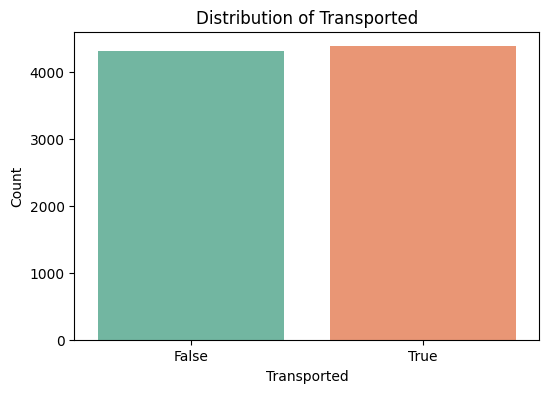

Transported
True     50.362361
False    49.637639
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='Transported', palette='Set2')
plt.title('Distribution of Transported')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

transported_rate = train['Transported'].value_counts(normalize=True) * 100
print(transported_rate)

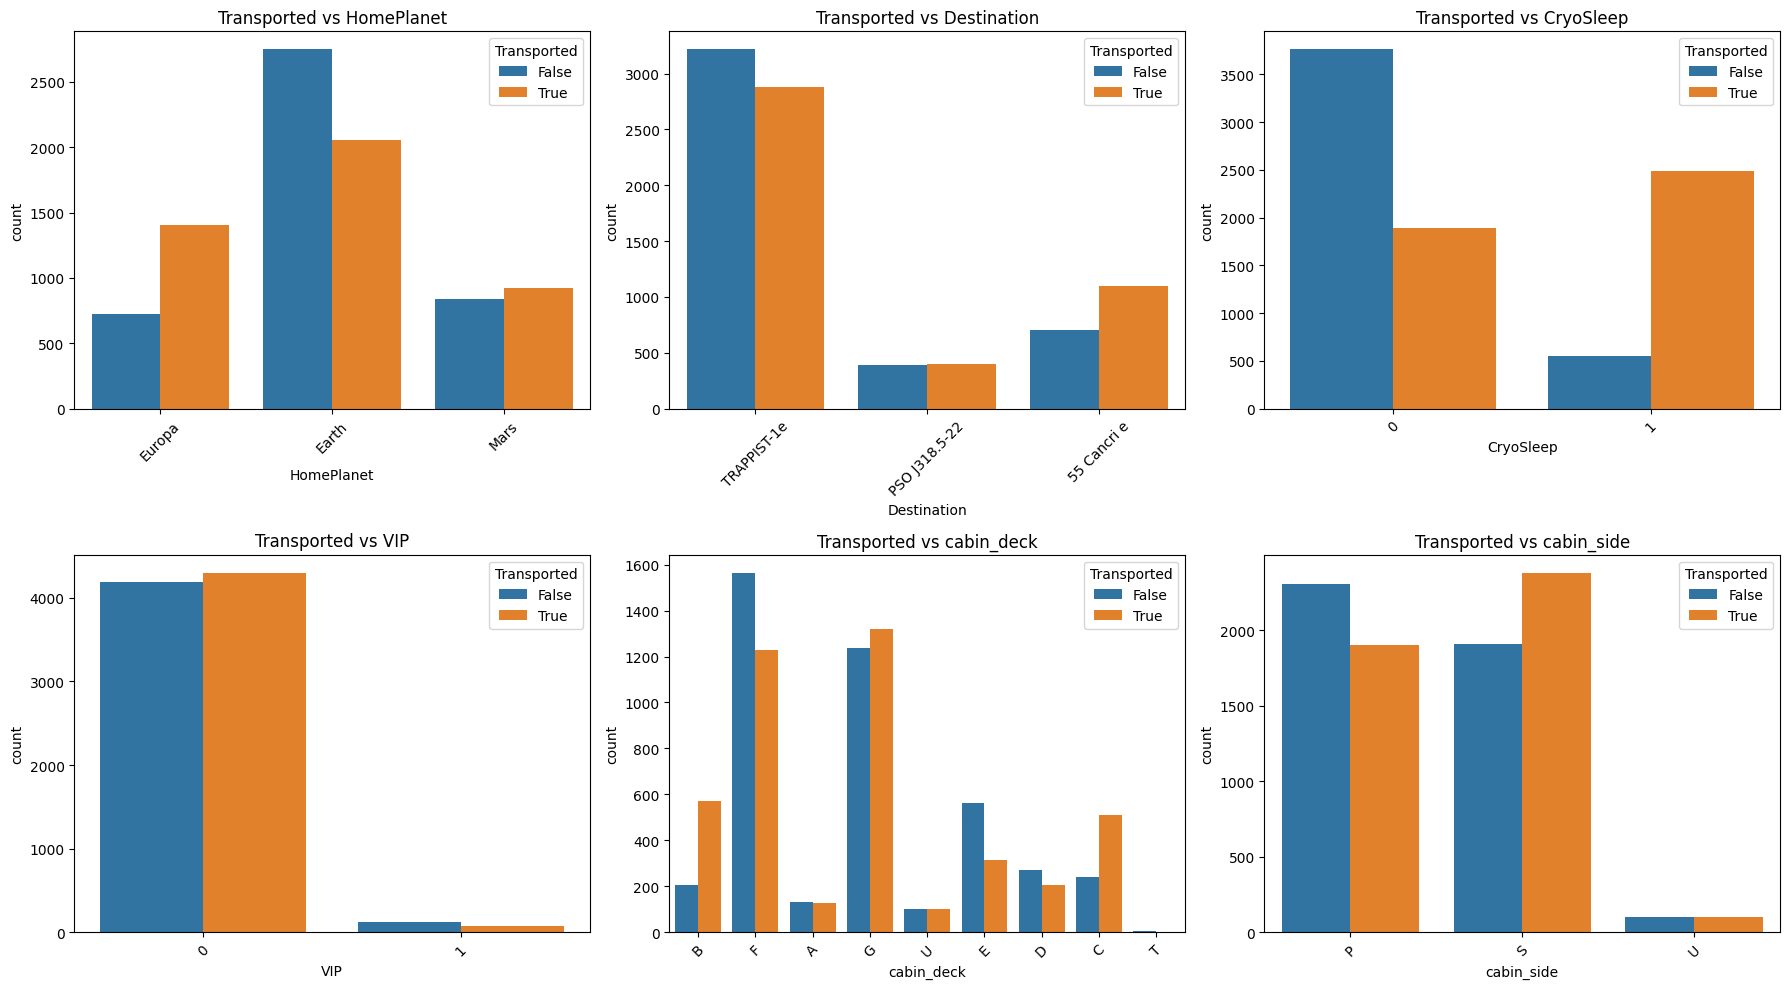

In [ ]:
cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'cabin_deck', 'cabin_side']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

axes = axes.flatten()

for i, col in enumerate(cols):
    sns.countplot(x=col, hue='Transported', data=train, ax=axes[i])
    axes[i].set_title(f"Transported vs {col}")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

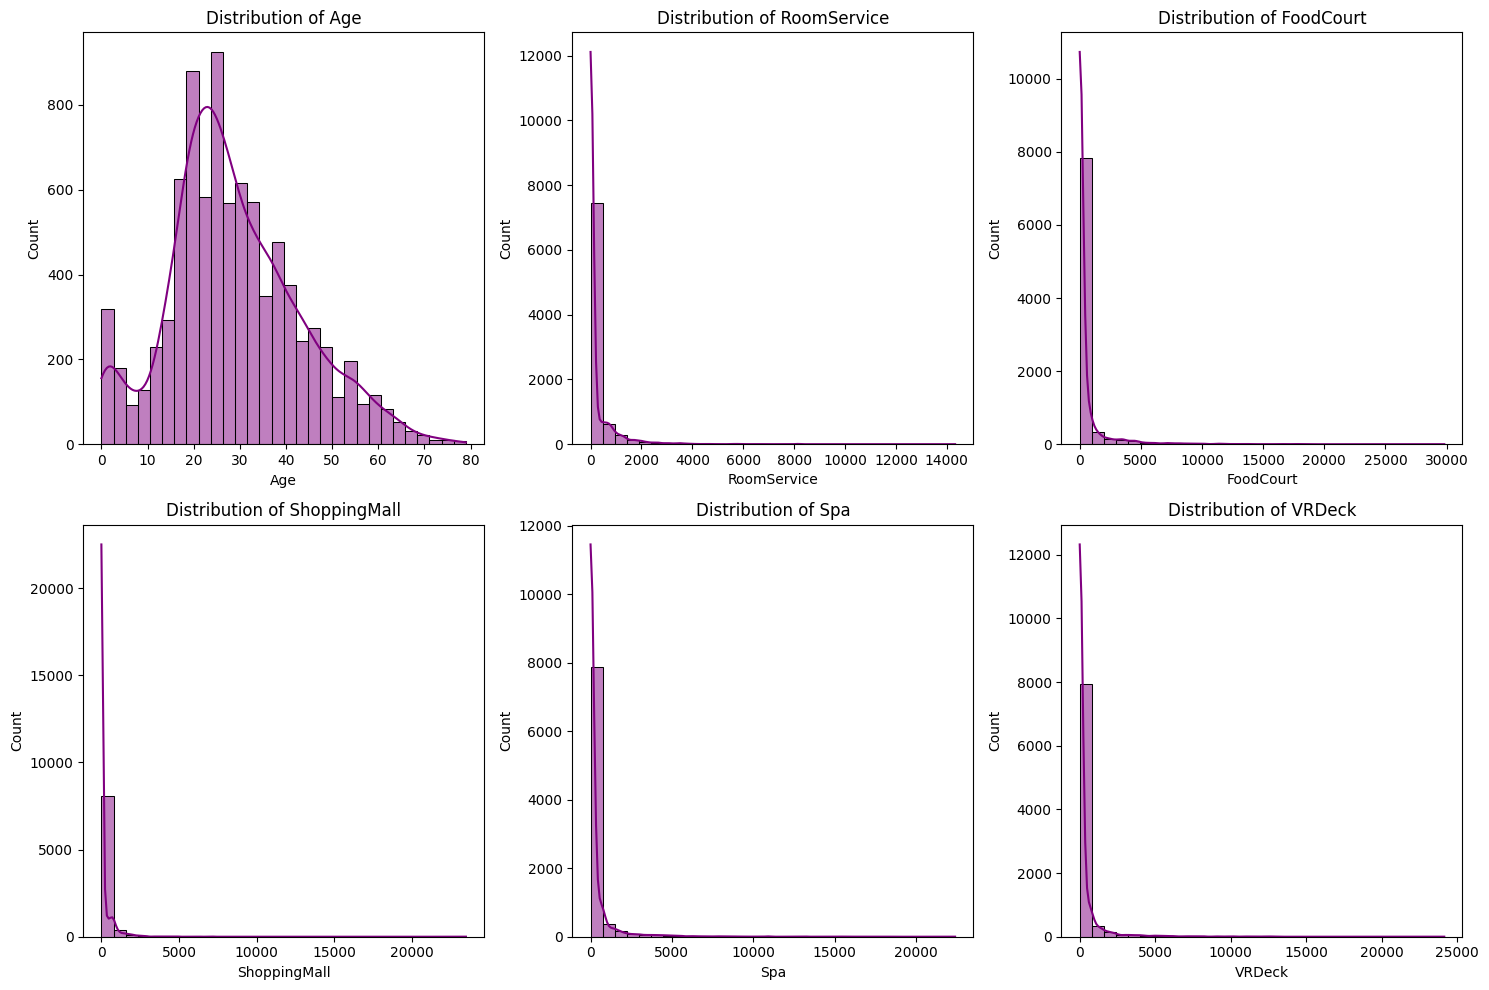

In [ ]:
spending_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

plt.figure(figsize=(15, 10))
for i, col in enumerate(spending_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(train[col], bins=30, kde=True, color='purple')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

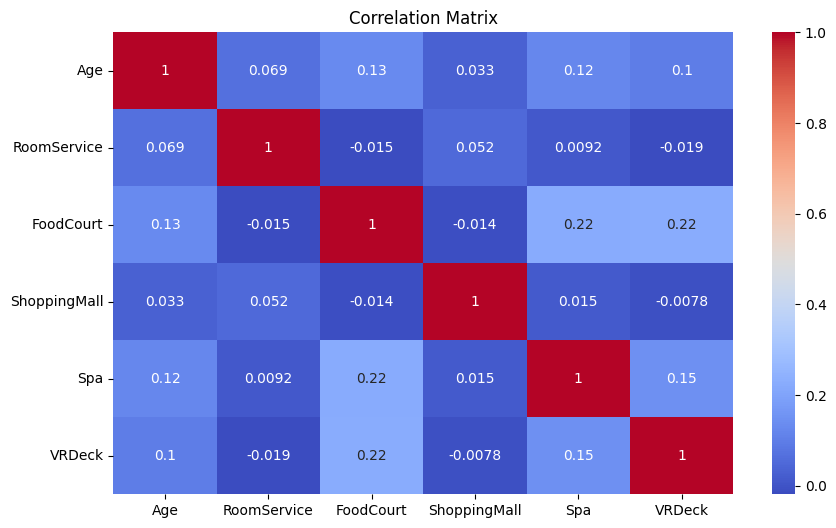

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# **Feature Engineering**

In [ ]:
drop_cols = ['PassengerId', 'Name', 'Cabin']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [ ]:
cat_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP','cabin_deck', 'cabin_side']

encoder = LabelEncoder()
for col in cat_cols:
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])

train['Transported'] = train['Transported'].astype(int)


### **Modeling**

# **RandomForestClassifier**

In [ ]:
X = train.drop('Transported', axis=1)
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 182,
    'max_depth': 12,
    'min_samples_split': 7,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42
}

rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=5, min_samples_split=7,
                       n_estimators=182, random_state=42)

In [ ]:
train_acc = accuracy_score(y_train, rf_model.predict(X_train))
test_acc = accuracy_score(y_test, rf_model.predict(X_test))

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8546
Test Accuracy: 0.7936


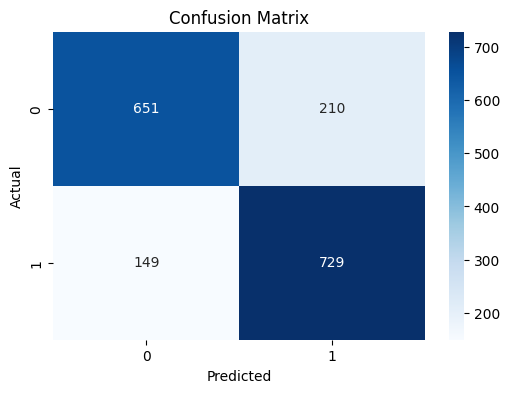

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       861
           1       0.78      0.83      0.80       878

    accuracy                           0.79      1739
   macro avg       0.80      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [ ]:
y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# **XGBClassifier**

In [ ]:
X = train.drop('Transported', axis=1)
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_params = {'learning_rate': 0.10351834573603554,
 'max_depth': 27, 'min_child_weight': 2,
 'gamma': 0.10869228780932577, 'subsample': 0.864437838782391,
 'colsample_bytree': 0.57183644394938, 'reg_alpha': 9.35926696957743,
 'reg_lambda': 6.8692006610911305}


xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.57183644394938, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.10869228780932577, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10351834573603554,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=27, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
train_acc = accuracy_score(y_train, xgb_model.predict(X_train))
test_acc = accuracy_score(y_test, xgb_model.predict(X_test))

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8434
Test Accuracy: 0.8028


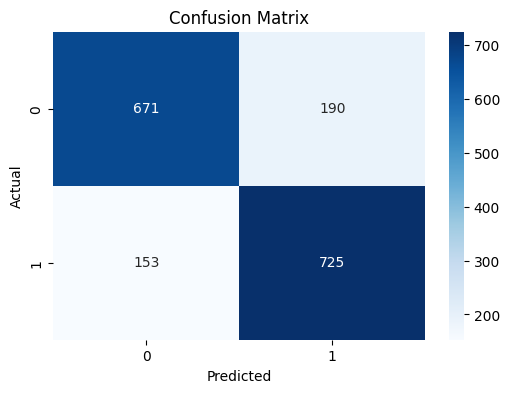

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       861
           1       0.79      0.83      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [ ]:
y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# **DL**

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X = train.drop('Transported', axis=1)
y = train['Transported'].astype(int)

selector = SelectKBest(mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]

X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1]))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Nadam(learning_rate=0.001),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Selected Features: ['HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'cabin_deck', 'cabin_num']
Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6164 - loss: 0.6955 - val_accuracy: 0.6743 - val_loss: 0.6448
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7121 - loss: 0.5491 - val_accuracy: 0.7124 - val_loss: 0.6103
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7441 - loss: 0.5186 - val_accuracy: 0.7664 - val_loss: 0.5724
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7437 - loss: 0.5134 - val_accuracy: 0.8037 - val_loss: 0.5133
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7547 - loss: 0.4954 - val_accuracy: 0.7937 - val_loss: 0.4693
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7630 - loss: 0.4823 - val_accuracy: 0.7958 - val_loss: 0.4375
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7786 - loss: 0.4692 - val_accur

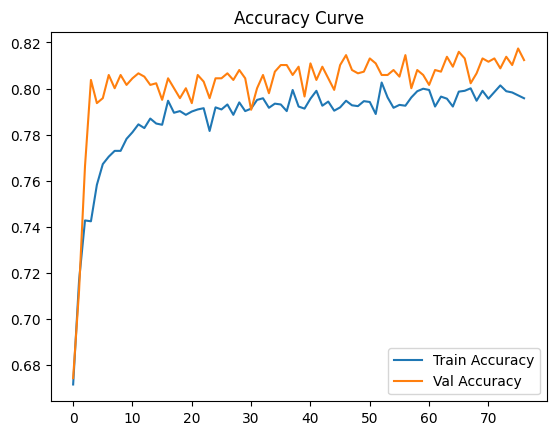

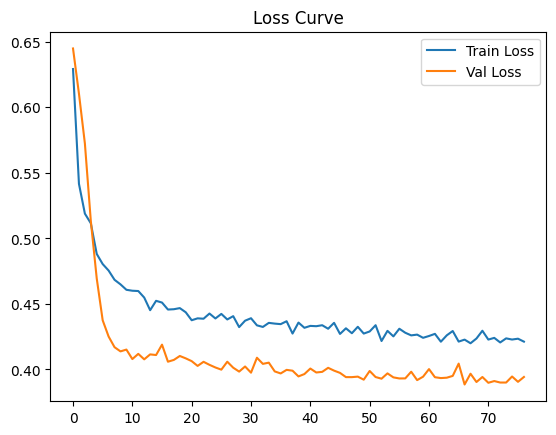

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# **Test & Save**

In [ ]:
test_predictions = xgb_model.predict(test)

In [ ]:
submission['Transported'] = test_predictions.astype(bool)

In [ ]:
submission.to_csv('sample_submission.csv', index=False)